In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### Data Pre-processing
**Checking Redundant Variable and Missing Values**

In [3]:
df.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

*Education and Education-num indicates same variable, let's remove them*

In [4]:
df = df.drop(columns=["education-num"],axis=1)

In [5]:
var_with_missing_vals = [var for var in df.columns if df[var].isnull().mean() > 0]

for var in var_with_missing_vals:
  print(df[var].unique())

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands' nan]


In [6]:
for var in df.columns:
  if '?' in df[var].unique():
    print(var)

workclass
occupation
native-country


In [7]:
#Let's convert them rows including "?" to null values.
for var in var_with_missing_vals:
  df[var] = df[var].replace('?', np.nan)

In [8]:
#Lets check the total number of null values again. 
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

*Let's check the values in the dependent variable*

In [9]:
df["income"].value_counts(normalize=True)*100

income
<=50K     50.612178
<=50K.    25.459645
>50K      16.053806
>50K.      7.874370
Name: proportion, dtype: float64

*There are unnecessasry puntuation in the values. Let's clean them.*

In [10]:
df["income"] = df["income"].str.strip(".")
df["income"].unique()

array(['<=50K', '>50K'], dtype=object)

In [11]:
# Step 1: Calculate missing value counts for each category of target variable

missing_values = {}

for var in var_with_missing_vals:
    missing = df[df[var].isnull()].groupby('income').size()
    total = df.groupby('income').size()
    proportion = (missing / total) * 100
    missing_values[var] = pd.DataFrame({'proportion': proportion})

In [12]:
missing_values["workclass"]

,proportion
income,
<=50K,6.820078
>50K,2.267477


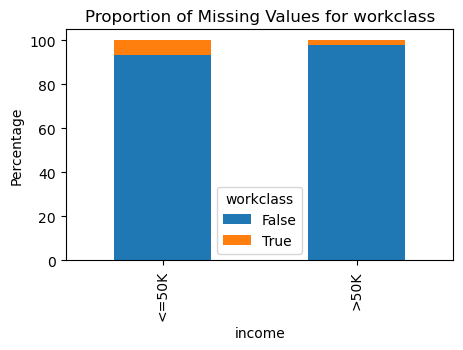

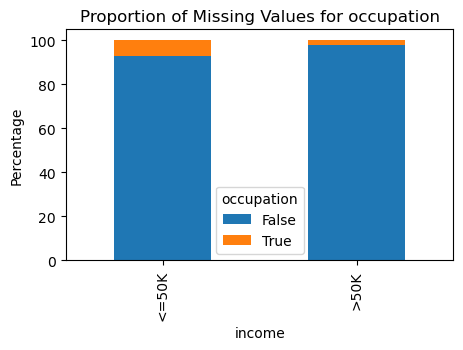

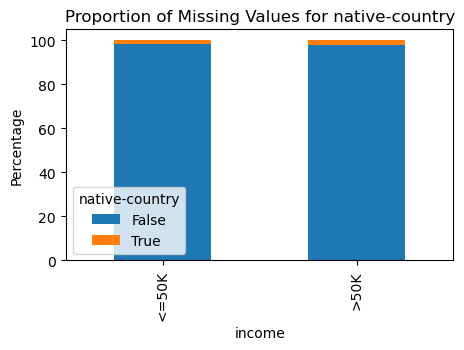

In [13]:
# Stacked bar plot for proportions
for var in var_with_missing_vals:
    missing_prop = pd.crosstab(df[var].isnull(), df['income'], normalize='columns') * 100
    missing_prop.T.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(f'Proportion of Missing Values for {var}')
    plt.ylabel('Percentage')
    plt.show()

*Since the proportion of missing values is negligible, we can drop them.*

In [14]:
cleaned_df = df.dropna()

**Encoding Categorical Variables**

In [15]:
# First Separate the dependent variable
X = cleaned_df.drop("income",axis=1)
y = cleaned_df["income"].values

In [16]:
X_dum = pd.get_dummies(X, drop_first=True)
X_dum.shape

(45222, 95)

In [17]:
y = np.where(y == '>50K',1,0)
np.unique(y)

array([0, 1])

### Model Development
**Train and Test Set Split**

In [27]:
from sklearn.model_selection import train_test_split
X_train_full, X_eval, y_train_full, y_eval = train_test_split(X_dum, y, test_size = 0.3, random_state = 0)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size = 0.3, random_state = 0)

**Logistic regression**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lgr_clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model on the training set
lgr_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_lgr = lgr_clf.predict(X_test)

# Evaluate the model
lg_accu = accuracy_score(y_test, y_pred_lgr)
lg_roc_auc = roc_auc_score(y_test, y_pred_lgr)

print('Logistic Regression Accuracy:', np.round(lg_accu*100,2))
print('Logistic Regression ROC AUC:', np.round(lg_roc_auc*100,2))

Logistic Regression Accuracy: 79.68
Logistic Regression ROC AUC: 61.55


**Gradient Boosting Classifier**

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_clf = GradientBoostingClassifier(n_estimators=100,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5)
# Fit the model on the training set
gbc_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_gbc = gbc_clf.predict(X_test)

# Evaluate the model
gbc_accu = accuracy_score(y_test, y_pred_gbc)
gbc_roc_auc = roc_auc_score(y_test, y_pred_gbc)

print('Gradient Boosting Classifier Accuracy:', np.round(gbc_accu*100,2))
print('Gradient Boosting Classifier ROC AUC:', np.round(gbc_roc_auc*100,2))

Gradient Boosting Classifier Accuracy: 84.55
Gradient Boosting Classifier ROC AUC: 71.59


**XGB Classifier (Extreme Gradient Boosting Classifier)**

In [35]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators = 100,
                        learning_rate = 0.05,
                        eval_metric = "logloss",
                        early_stopping_rounds = 5,
                        n_jobs = -1)
# Fit the model on the training set
xgb_clf.fit(X_train, y_train,
            eval_set = [(X_eval,y_eval)],
            verbose = False)

# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the model
xgb_accu = accuracy_score(y_test, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)

print('Xtreme Boosting Classifier Accuracy:', np.round(xgb_accu*100,2))
print('Xtreme Boosting Classifier ROC AUC:', np.round(xgb_roc_auc*100,2))

Xtreme Boosting Classifier Accuracy: 86.89
Xtreme Boosting Classifier ROC AUC: 77.73


In [36]:
result = {
    "Accuracies":[lg_accu,gbc_accu,xgb_accu],
    "ROC_AUC":[lg_roc_auc, gbc_roc_auc, xgb_roc_auc]
}
result_df = pd.DataFrame(result)
result_df

,Accuracies,ROC_AUC
0,0.796778,0.615530
1,0.845530,0.715851
2,0.868906,0.777289


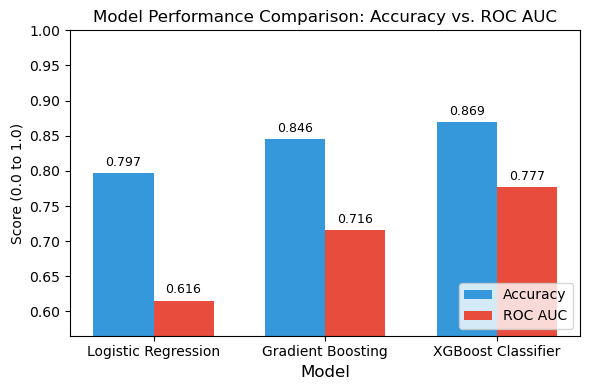

In [42]:
model_names = ["Logistic Regression", "Gradient Boosting", "XGBoost Classifier"]
result_df = pd.DataFrame(result, index=model_names)

# 2. Create the Grouped Bar Chart
fig, ax = plt.subplots(figsize=(6, 4))

# Define the bar width and positions
bar_width = 0.35
index = np.arange(len(result_df.index))

# Plot 'Accuracies'
bar1 = ax.bar(index - bar_width/2, result_df['Accuracies'], bar_width, label='Accuracy', color='#3498db')

# Plot 'ROC_AUC'
bar2 = ax.bar(index + bar_width/2, result_df['ROC_AUC'], bar_width, label='ROC AUC', color='#e74c3c')

# Add labels, title, and customize x-ticks
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score (0.0 to 1.0)', fontsize=10)
ax.set_title('Model Performance Comparison: Accuracy vs. ROC AUC', fontsize=12)
ax.set_xticks(index)
ax.set_xticklabels(result_df.index, rotation=0)
ax.legend(loc='lower right')
ax.set_ylim(min(result_df.min()) - 0.05, 1.0) # Adjust Y-axis scale

# Function to add value labels on top of the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show() # Use plt.show() to display the plot in a standard Python environment

In [44]:
plt.savefig('model_comparison_bar_chart.jpg')

<Figure size 640x480 with 0 Axes>